In [1]:
#importing the libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras import utils,models,layers
import seaborn as sns
from tensorflow.keras.datasets import mnist
from tensorflow.keras.initializers import RandomNormal

import keras
from keras import optimizers
from keras.models import Model
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, Flatten, Dropout, MaxPooling2D, AveragePooling2D
from sklearn.ensemble import RandomForestClassifier
import os
import glob as gb
import cv2
from PIL import Image



---


**Preprocessing**

I will be training the YOLO v1 on the **widerFace dataset** that is used for face detection

Number of classes : 1

Size of the dataset: 32K images

In [2]:
import os

S = 7
B = 2
C = 1

def parse_widerface_labels(txt_path, image_dir):
    labels = []
    image_paths = []

    with open(txt_path, 'r') as f:
        lines = f.readlines()

    i = 0
    while i < len(lines):

        if i + 1 < len(lines):
            try:
                # Attempt to read the number of boxes from the next line
                num_boxes = int(lines[i + 1].strip())

                # If successful, process the image path and boxes
                path = lines[i].strip()
                img_path = os.path.join(image_dir, path)
                boxes = []

                # preventing out of bounds error
                if i + 2 + num_boxes <= len(lines):
                    for j in range(num_boxes):
                        vals = list(map(int, lines[i + 2 + j].strip().split()))
                        x, y, w, h = vals[:4]
                        boxes.append((x, y, x + w, y + h))  # (xmin, ymin, xmax, ymax)

                    labels.append(boxes)
                    image_paths.append(img_path)

                    i += 2 + num_boxes
                else:
                    break

            except ValueError:
                 i += 1

        else:

            break

    return image_paths, labels

# The load_widerface_dataset function remains the same
def load_widerface_dataset(label_path, image_dir, limit=None):
    paths, all_boxes = parse_widerface_labels(label_path, image_dir)
    images = []
    labels = []

    for idx, (img_path, boxes) in enumerate(zip(paths, all_boxes)):
        if limit and idx >= limit:
            break
        try:
            img = Image.open(img_path).convert('RGB')
            w, h = img.size
            label = create_label_tensor(boxes, (w, h))
            img = preprocess_image(img_path)
            images.append(img)
            labels.append(label)
        except FileNotFoundError:
             print(f"Skipping {img_path}: File not found.")
             continue
        except Exception as e:
            print(f"Skipping {img_path} due to processing error: {e}")
            continue


    # Convert lists to numpy arrays outside the loop for efficiency
    return np.array(images), np.array(labels)

# Keep the existing preprocess_image and create_label_tensor functions
def preprocess_image(path, target_size=(448, 448)):
    img = Image.open(path).convert('RGB')
    img = img.resize(target_size)
    return np.array(img) / 255.0  # Normalize

def create_label_tensor(boxes, original_size, S=7, B=2, C=1):
    label = np.zeros((S, S, B * 5 + C))
    W, H = original_size

    for box in boxes:
        xmin, ymin, xmax, ymax = box
        x_center = (xmin + xmax) / 2 / W
        y_center = (ymin + ymax) / 2 / H
        bw = (xmax - xmin) / W
        bh = (ymax - ymin) / H

        i = int(x_center * S)
        j = int(y_center * S)
        if i >= S: i = S - 1
        if j >= S: j = S - 1

        x_cell = x_center * S - i
        y_cell = y_center * S - j

        if label[j, i, 4] == 0:  # Only one object per cell
            label[j, i, 0:5] = [x_cell, y_cell, bw, bh, 1]
            label[j, i, 5] = 1  # one-hot vector = face

    return label

In [3]:
def load_widerface_dataset(label_path, image_dir, limit=None):
    paths, all_boxes = parse_widerface_labels(label_path, image_dir)
    images = []
    labels = []

    for idx, (img_path, boxes) in enumerate(zip(paths, all_boxes)):
        if limit and idx >= limit:
            break
        try:
            img = Image.open(img_path).convert('RGB')
            w, h = img.size
            label = create_label_tensor(boxes, (w, h))
            img = preprocess_image(img_path)
            images.append(img)
            labels.append(label)
        except Exception as e:
            print(f"Skipping {img_path}: {e}")
            continue

    return np.array(images), np.array(labels)

In [9]:
with tf.device('/GPU:0'):
  images, labels = load_widerface_dataset(
      label_path='/content/wider_face_val_bbx_gt.txt',
      image_dir='/content/drive/MyDrive/WIDER_train/images',
      limit = 1000
  )

Skipping /content/drive/MyDrive/WIDER_train/images/0--Parade/0_Parade_marchingband_1_465.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/WIDER_train/images/0--Parade/0_Parade_marchingband_1_465.jpg'
Skipping /content/drive/MyDrive/WIDER_train/images/0--Parade/0_Parade_Parade_0_628.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/WIDER_train/images/0--Parade/0_Parade_Parade_0_628.jpg'
Skipping /content/drive/MyDrive/WIDER_train/images/0--Parade/0_Parade_marchingband_1_765.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/WIDER_train/images/0--Parade/0_Parade_marchingband_1_765.jpg'
Skipping /content/drive/MyDrive/WIDER_train/images/0--Parade/0_Parade_Parade_0_194.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/WIDER_train/images/0--Parade/0_Parade_Parade_0_194.jpg'
Skipping /content/drive/MyDrive/WIDER_train/images/0--Parade/0_Parade_marchingband_1_379.jpg: [Errno 2] No such file or directory: '/content/drive/MyDrive/W

**Architecture of YOLOv1**
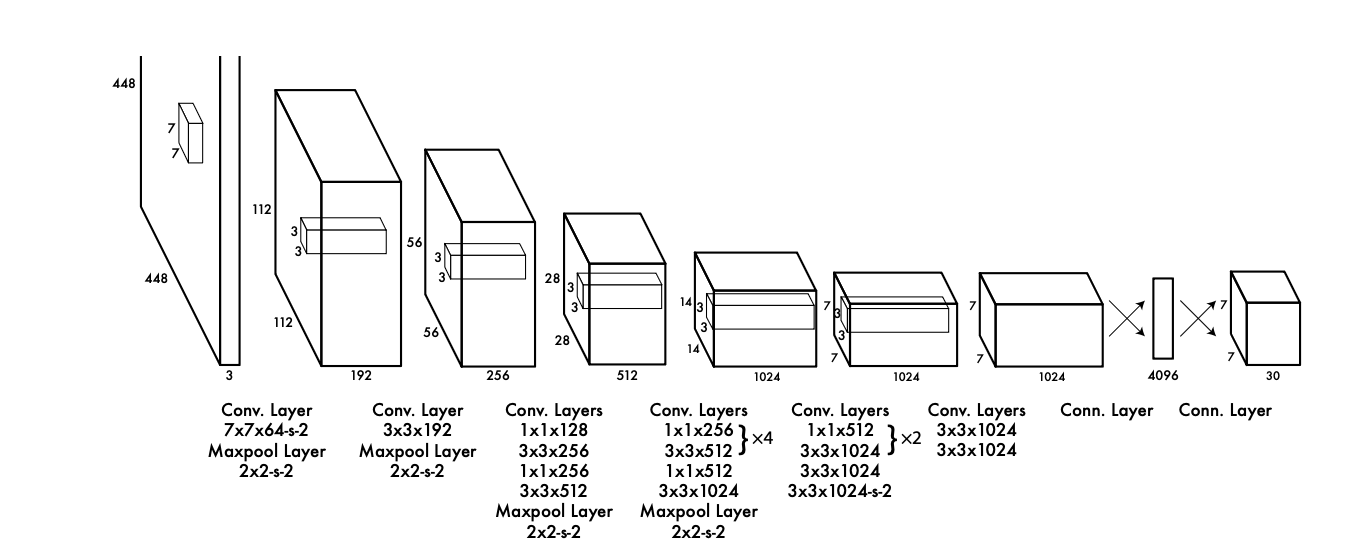

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras.backend as K # Import Keras backend

def YOLO(S = 7, B = 2, C = 1):

    inputs = tf.keras.Input(shape=(448, 448, 3))

    # Layer 1: Conv + MaxPooling
    x = layers.Conv2D(64, (7, 7), strides=2, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), strides=2, padding='same')(x)

    # Layer 2: Conv + MaxPooling
    x = layers.Conv2D(192, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=2, padding='same')(x)

    # Layer 3-6: 1x1 and 3x3 convolutions + MaxPooling
    x = layers.Conv2D(128, (1, 1), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = layers.Conv2D(256, (1, 1), activation='relu', padding='same')(x)
    x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=2, padding='same')(x)

    # Layer 7-14: 4 times Repeated 1x1 and 3x3 convolutions
    for i in range(4):
        x = layers.Conv2D(256, (1, 1), activation='relu', padding='same')(x)
        x = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(x)

    # Layer 15-18: 1x1 and 3x3 convolutions + MaxPooling
    x = layers.Conv2D(512, (1, 1), activation='relu', padding='same')(x)
    x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), strides=2, padding='same')(x)

    # Layer 19-22: 2 times Repeated 1x1 and 3x3 convolutions
    for i in range(2):
        x = layers.Conv2D(512, (1, 1), activation='relu', padding='same')(x)
        x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)

    # Layer 23-24: 3x3 convolutions
    x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
    # Reduce stride here to potentially avoid zero dimensions later
    x = layers.Conv2D(1024, (3, 3), strides=1, activation='relu', padding='same')(x)

    # Layer 25-26: 3x3 convolutions with reduced stride
    for i in range(2):
        x = layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(x)

    # Add Average Pooling before Flatten to reduce spatial dimensions
    # The spatial dimensions before this are expected to be 14x14
    x = layers.AveragePooling2D((14, 14))(x)


    # Final layers
    x = layers.Flatten()(x)
    x = layers.Dense(4096, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    output_units = S * S * (B * 5 + C)
    x = layers.Dense(output_units, activation='linear')(x)

    model = models.Model(inputs=inputs, outputs=x)
    return model



**LOSS function specific to YOLO v1:**
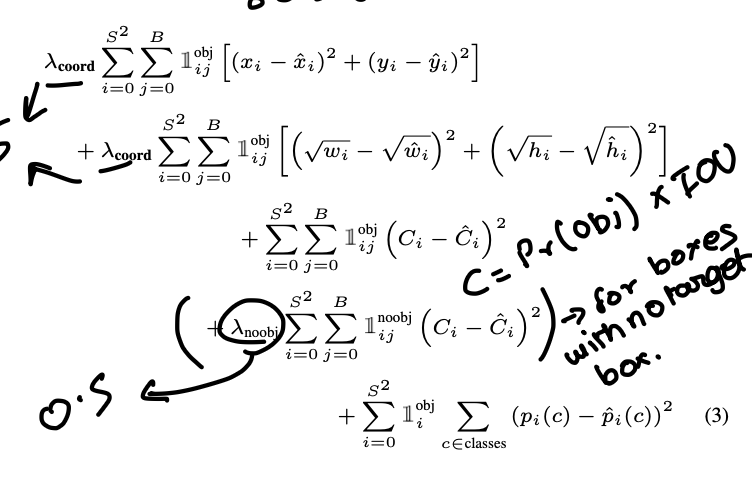

In [11]:
import tensorflow.keras.backend as K

def yolo_loss(y_true, y_pred, S=7, B=2, C=20, λ_coord=5, λ_noobj=0.5):
    y_true = K.reshape(y_true, (-1, S, S, B * 5 + C))
    y_pred = K.reshape(y_pred, (-1, S, S, B * 5 + C))


    pred_box = y_pred[..., :B*5]  # x, y, w, h, confidence
    pred_class = y_pred[..., B*5:]  # class probabilities

    true_box = y_true[..., :B*5]
    true_class = y_true[..., B*5:]

    # Coordinate loss
    coord_mask = y_true[..., 4:5]
    xy_loss = λ_coord * K.sum(coord_mask * K.square(true_box[..., 0:2] - pred_box[..., 0:2]))
    wh_loss = λ_coord * K.sum(coord_mask * K.square(K.sqrt(K.abs(true_box[..., 2:4])) - K.sqrt(K.abs(pred_box[..., 2:4]))))

    # Confidence loss
    obj_conf = λ_coord * K.sum(coord_mask * K.square(true_box[..., 4:5] - pred_box[..., 4:5]))
    noobj_conf = λ_noobj * K.sum((1 - coord_mask) * K.square(true_box[..., 4:5] - pred_box[..., 4:5]))

    # Classification loss
    class_loss = K.sum(coord_mask * K.square(true_class - pred_class))

    return xy_loss + wh_loss + obj_conf + noobj_conf + class_loss

In [12]:

with tf.device('/GPU:0'):
  model = YOLO()
model.compile(optimizer='adam', loss=yolo_loss)